In [ ]:
import pandas as pd
import numpy as np
import tejapi
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
tej_key = 'YOUR KEY HERE'  # Replace with your actual TEJ API key
tejapi.ApiConfig.api_key = tej_key
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key


from zipline.sources.TEJ_Api_Data import get_universe
import TejToolAPI
from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record, order_target_percent
from zipline.finance import commission, slippage
from zipline import run_algorithm

In [21]:
start_date = '2010-01-01'; end_date = '2025-05-27'

pool = get_universe(start = start_date,
                      end = end_date,
                      mkt_bd_e = ['TSE', 'OTC'],
                      stktp_e = ['Common Stock-Foreign','Common Stock'])

columns = ['coid', 'roi', 'mktcap', 'r505', 'r104', 'per', 'close_d', 'r316']

start_dt = pd.Timestamp(start_date, tz = 'UTC')
end_dt = pd.Timestamp(end_date, tz = "UTC")

data_use = TejToolAPI.get_history_data(start = start_dt,
                                    end = end_dt,
                                    ticker = pool + ['IR0001'],
                                    fin_type = ['Q', 'TTM'], 
                                    columns = columns,
                                    transfer_to_chinese = False)

Currently used TEJ API key call quota 450/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 79669758/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 537/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 86426738/9223372036854775807 (0.0%)


In [22]:
data_use['mdate'] = pd.to_datetime(data_use['mdate'])
data_use = data_use.sort_values('mdate')
data_use['avg_market_cap'] = data_use.groupby('mdate')['Market_Cap_Dollars'].transform('mean')
data_use['avg_debt_ratio'] = data_use.groupby('mdate')['Liabilities_Ratio_Q'].transform('mean')

data_use['EPS_5y_ago'] = data_use.groupby('coid')['Net_Income_Per_Share_Q'].shift(252 * 5)
data_use['EPS_CAGR_5Y'] = ((data_use['Net_Income_Per_Share_Q'] / data_use['EPS_5y_ago']) ** (1/5)) - 1


# 以 126 個交易日作為近 6 個月（可依台股調整為 120～130 天）
data_use['ret_6m'] = data_use.groupby('coid')['Close'].transform(lambda x: x / x.shift(126) - 1)

# 從 df 中抽出大盤（IR0001）的每日報酬率
market_ret = data_use[data_use['coid'] == 'IR0001'][['mdate', 'ret_6m']].rename(columns={'ret_6m': 'market_ret_6m'})

# 把 market_ret 併回所有資料（用日期對齊）
data_use = data_use.merge(market_ret, on='mdate', how='left')
data_use['RS_ratio_6m'] = data_use['ret_6m'] / data_use['market_ret_6m']
data_use['mdate_shifted'] = data_use.groupby('coid')['mdate'].shift(1)

In [26]:
def compute_stock(date, data):
    
    df = data[data['mdate_shifted'] == pd.to_datetime(date)].reset_index(drop = True)

    set_1 = set(df[df['Market_Cap_Dollars'] >= df['avg_market_cap']]['coid'])

    set_2 = set(df[df['EPS_CAGR_5Y'] >= .1]['coid'])

    set_3 = set(df[df['Net_Income_Per_Share_TTM'] >= .15]['coid'])

    set_4 = set(df[df['Liabilities_Ratio_Q'] < df['avg_debt_ratio']]['coid'])

    set_5 = set(df[(df['PER_TWSE'] <= df['EPS_CAGR_5Y']*100 * 2.0)]['coid'])

    set_6 = set(df[(df['RS_ratio_6m'] > 1)]['coid'])

    tickers = list(set_1 & set_2 &  set_3 & set_4 & set_6 & set_5)
    print(f'set1:{len(set_1)}, set2:{len(set_2)},set3:{len(set_3)},set4:{len(set_4)},set5:{len(set_5)},set6:{len(set_6)}')

    sets = [len(set_1), len(set_2),len(set_3), len(set_4),len(set_5), len(set_6)]

    return tickers, sets

# sets = [set_1, set_2,set_3, set_4,set_5, set_6]


In [17]:
pools = pool + ['IR0001']

start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

print(f'開始匯入回測資料')
simple_ingest(name = 'tquant' , tickers = pools , start_date = start_ingest , end_date = end_ingest)
print(f'結束匯入回測資料')

開始匯入回測資料
Now ingesting data.


[2025-05-29 08:54:04.503119] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 449/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 73607725/9223372036854775807 (0.0%)


[2025-05-29 08:59:03.713460] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20100101', tz = 'utc'),end_dt = pd.Timestamp('20250527' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 449/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 73607725/9223372036854775807 (0.0%)
結束匯入回測資料


In [38]:
def initialize(context, re = 30):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))

    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []
    context.rebalance = re
    context.set1 = 0
    context.set2 = 0
    context.set3 = 0
    context.set4 = 0
    context.set5 = 0
    context.set = 0

    context.dic = {}

def handle_data_1(context, data):
    # 避免前視偏誤，在篩選股票下一交易日下單
    if context.state == True:

        for i in context.last_tickers:
            if i not in context.order_tickers:
                order_target_percent(symbol(i), 0)


        for i in context.order_tickers:
            order_target_percent(symbol(i), 1.0 / len(context.order_tickers))
            context.dic[i] = data.current(symbol(i), 'price')

        record(p = context.dic)
        context.dic = {}

        print(f"下單日期：{data.current_dt.date()}, 擇股股票數量：{len(context.order_tickers)}, Leverage: {context.account.leverage}")
        context.last_tickers = context.order_tickers.copy()
        context.state = False

    backtest_date = data.current_dt.date()

    if context.i % context.rebalance == 0:
        context.state = True
        context.order_tickers = compute_stock(date = backtest_date, data = data_use)[0]
        context.set = compute_stock(date = backtest_date, data = data_use)[1]


    record(tickers = context.order_tickers)
    record(Leverage = context.account.leverage)
    
    if context.account.leverage > 1.2:
        print(f'{data.current_dt.date()}: Over Leverage, Leverage: {context.account.leverage}')
        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

    context.i += 1
    lengths = [s for s in context.set]

    record(
        ticker_num = len(context.order_tickers),
        set1_len = lengths[0],
        set2_len = lengths[1],
        set3_len = lengths[2],
        set4_len = lengths[3],
        set5_len = lengths[4],
        set6_len = lengths[5]
    )

    

set1:114, set2:287,set3:1127,set4:798,set5:312,set6:857
set1:114, set2:287,set3:1127,set4:798,set5:312,set6:857
下單日期：2016-01-05, 擇股股票數量：6, Leverage: 0.0
set1:114, set2:283,set3:1125,set4:798,set5:308,set6:835
set1:114, set2:283,set3:1125,set4:798,set5:308,set6:835
下單日期：2016-02-24, 擇股股票數量：3, Leverage: 0.95827899997932
set1:114, set2:212,set3:1134,set4:804,set5:223,set6:831
set1:114, set2:212,set3:1134,set4:804,set5:223,set6:831
下單日期：2016-04-11, 擇股股票數量：4, Leverage: 0.9981592908808948
set1:115, set2:255,set3:1149,set4:825,set5:266,set6:878
set1:115, set2:255,set3:1149,set4:825,set5:266,set6:878
下單日期：2016-05-24, 擇股股票數量：5, Leverage: 1.0079541581949976
set1:113, set2:245,set3:1147,set4:824,set5:272,set6:605
set1:113, set2:245,set3:1147,set4:824,set5:272,set6:605
下單日期：2016-07-06, 擇股股票數量：3, Leverage: 0.9877056351068045
set1:112, set2:287,set3:1157,set4:834,set5:290,set6:419
set1:112, set2:287,set3:1157,set4:834,set5:290,set6:419
下單日期：2016-08-18, 擇股股票數量：2, Leverage: 1.0012454826336663
set1:117,

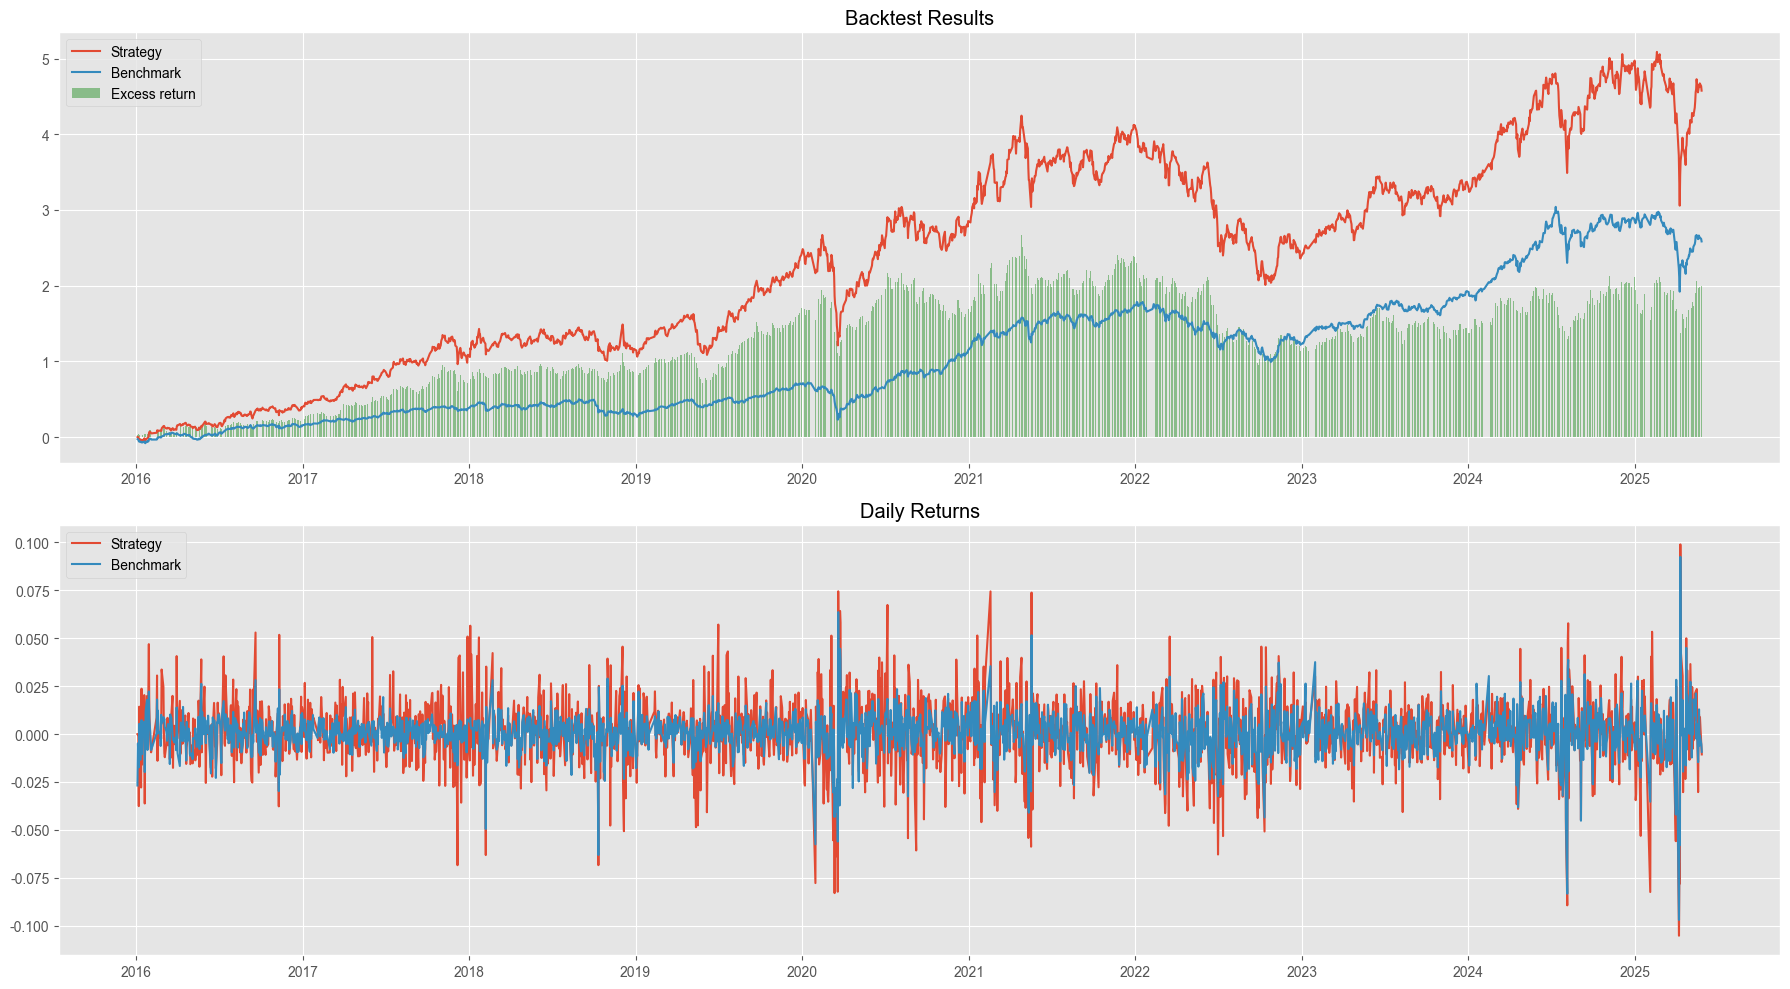

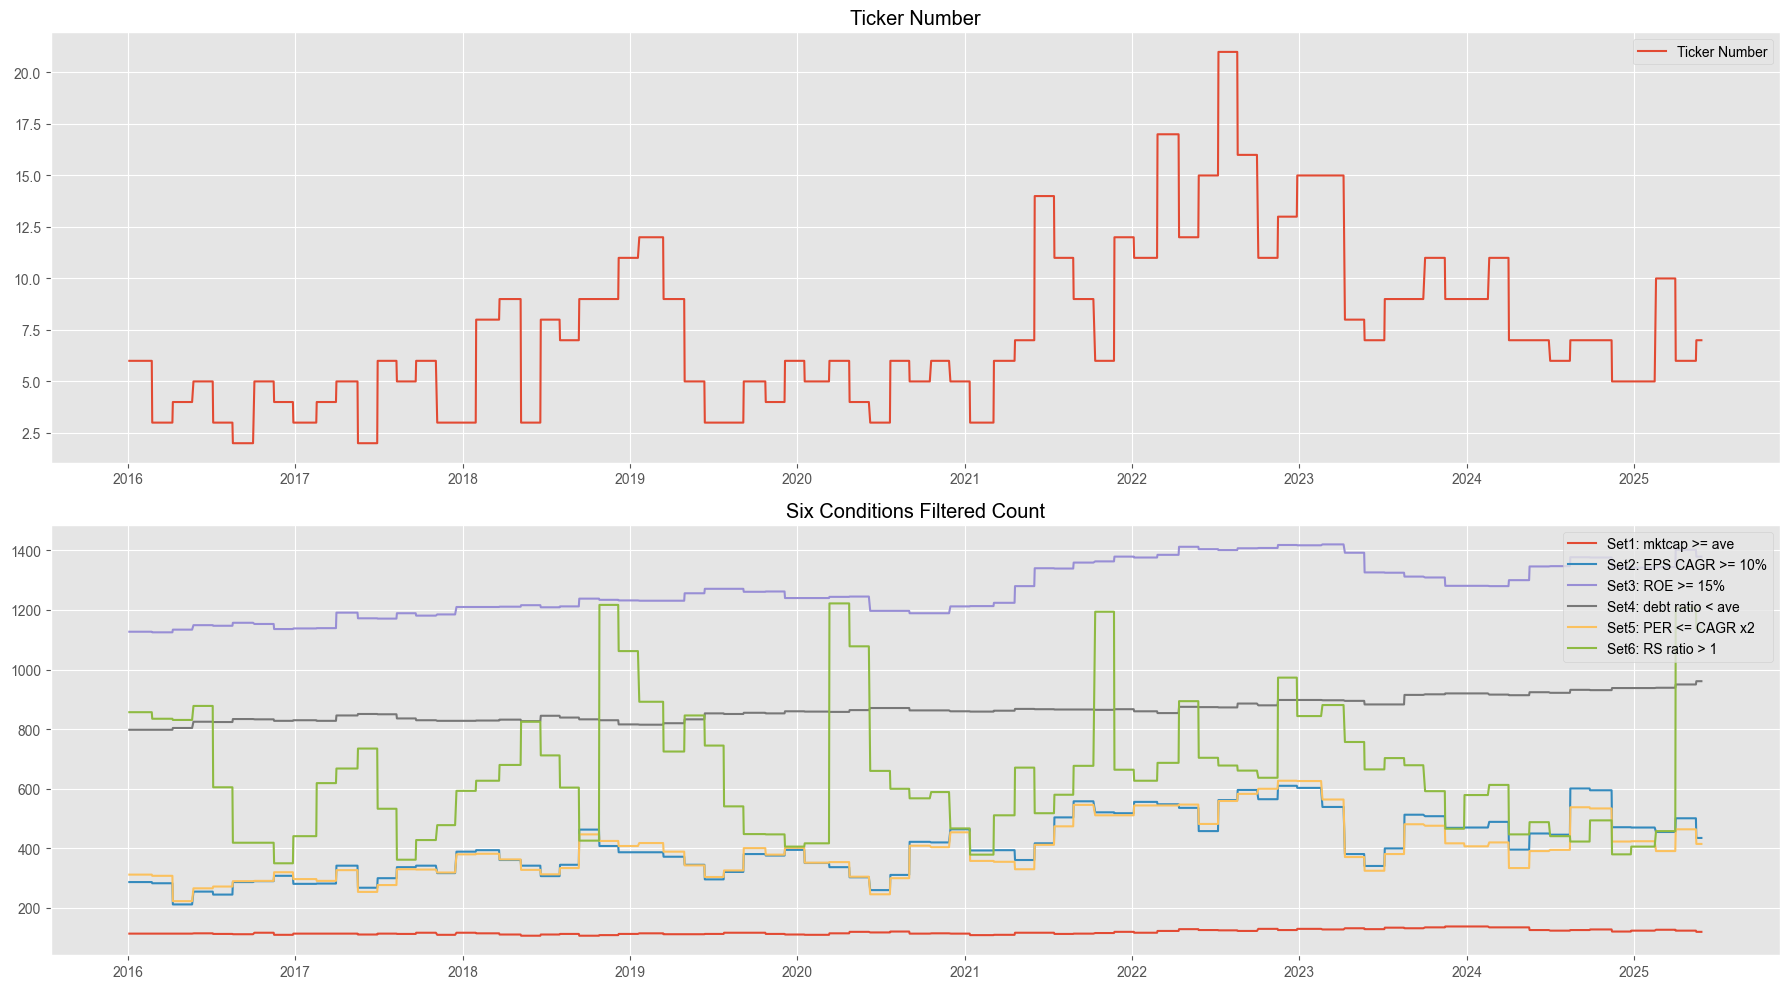

In [39]:
def analyze(context, perf):

  plt.style.use('ggplot')

  # 第一張圖：策略績效與報酬
  fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)

  axes1[0].plot(perf.index, perf['algorithm_period_return'], label='Strategy')
  axes1[0].plot(perf.index, perf['benchmark_period_return'], label='Benchmark')
  axes1[0].bar(perf.index, perf['algorithm_period_return'] - perf['benchmark_period_return'],
              label='Excess return', color='g', alpha=0.4)
  axes1[0].set_title("Backtest Results")
  axes1[0].legend()

  axes1[1].plot(perf.index, perf['returns'], label='Strategy')
  axes1[1].plot(perf.index, perf['benchmark_return'], label='Benchmark')
  axes1[1].set_title("Daily Returns")
  axes1[1].legend()

  plt.tight_layout()
  plt.show()

  # 第二張圖：選股結構與篩選條件
  fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False)

  axes2[0].plot(perf.index, perf['ticker_num'], label='Ticker Number')
  axes2[0].set_title("Ticker Number")
  axes2[0].legend()

  axes2[1].plot(perf.index, perf['set1_len'], label='Set1: mktcap >= ave')
  axes2[1].plot(perf.index, perf['set2_len'], label='Set2: EPS CAGR >= 10%')
  axes2[1].plot(perf.index, perf['set3_len'], label='Set3: ROE >= 15%')
  axes2[1].plot(perf.index, perf['set4_len'], label='Set4: debt ratio < ave')
  axes2[1].plot(perf.index, perf['set5_len'], label='Set5: PER <= CAGR x2')
  axes2[1].plot(perf.index, perf['set6_len'], label='Set6: RS ratio > 1')
  axes2[1].set_title("Six Conditions Filtered Count")
  axes2[1].legend(loc='upper right')

  plt.tight_layout()
  plt.show()


results = run_algorithm(
            start = pd.Timestamp('2016-01-01', tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_1,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e5)

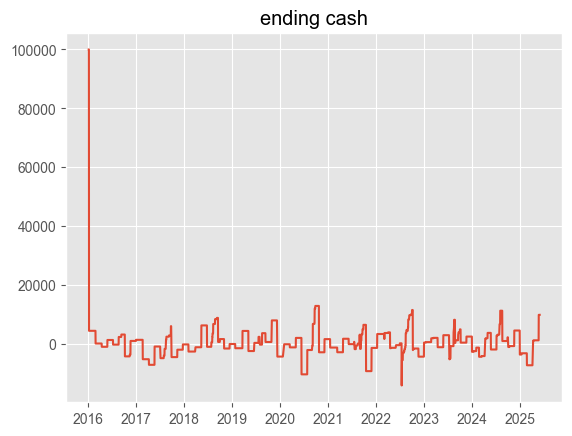

In [40]:
plt.plot(results['period_open'], results['ending_cash'])
plt.title('ending cash')
plt.show()

Start date,2016-01-04
End date,2025-05-27
Total months,108
,Backtest
Annual return,20.836%
Cumulative returns,457.538%
Annual volatility,27.783%
Sharpe ratio,0.82
Calmar ratio,0.49
Stability,0.86
Max drawdown,-42.613%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.61,2021-04-26,2022-10-13,2024-05-16,746
1,39.74,2020-02-14,2020-03-19,2020-07-06,96
2,33.36,2025-02-18,2025-04-09,NaT,NaN
3,22.67,2024-07-10,2024-08-05,2024-10-18,67
4,20.55,2019-05-07,2019-06-06,2019-07-24,56


Top 10 long positions of all time,max
sid,
8299,56.38%
2330,51.99%
3008,49.69%
5269,44.57%
3105,44.40%
3532,43.80%
3034,39.67%
2915,36.84%
6415,36.74%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
8299,56.38%
2330,51.99%
3008,49.69%
5269,44.57%
3105,44.40%
3532,43.80%
3034,39.67%
2915,36.84%
6415,36.74%


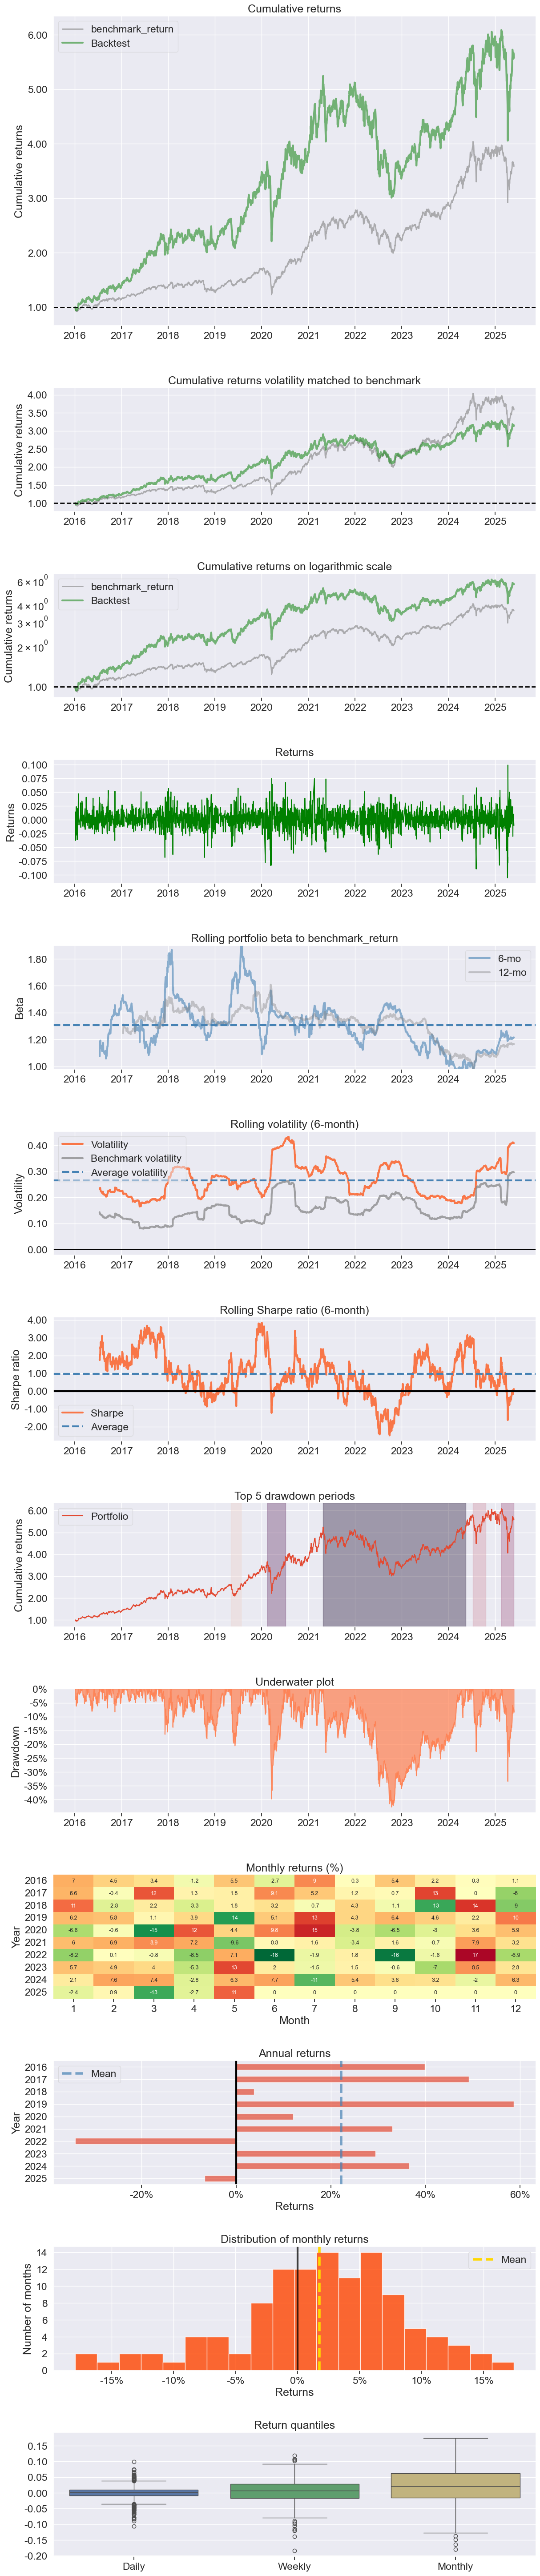

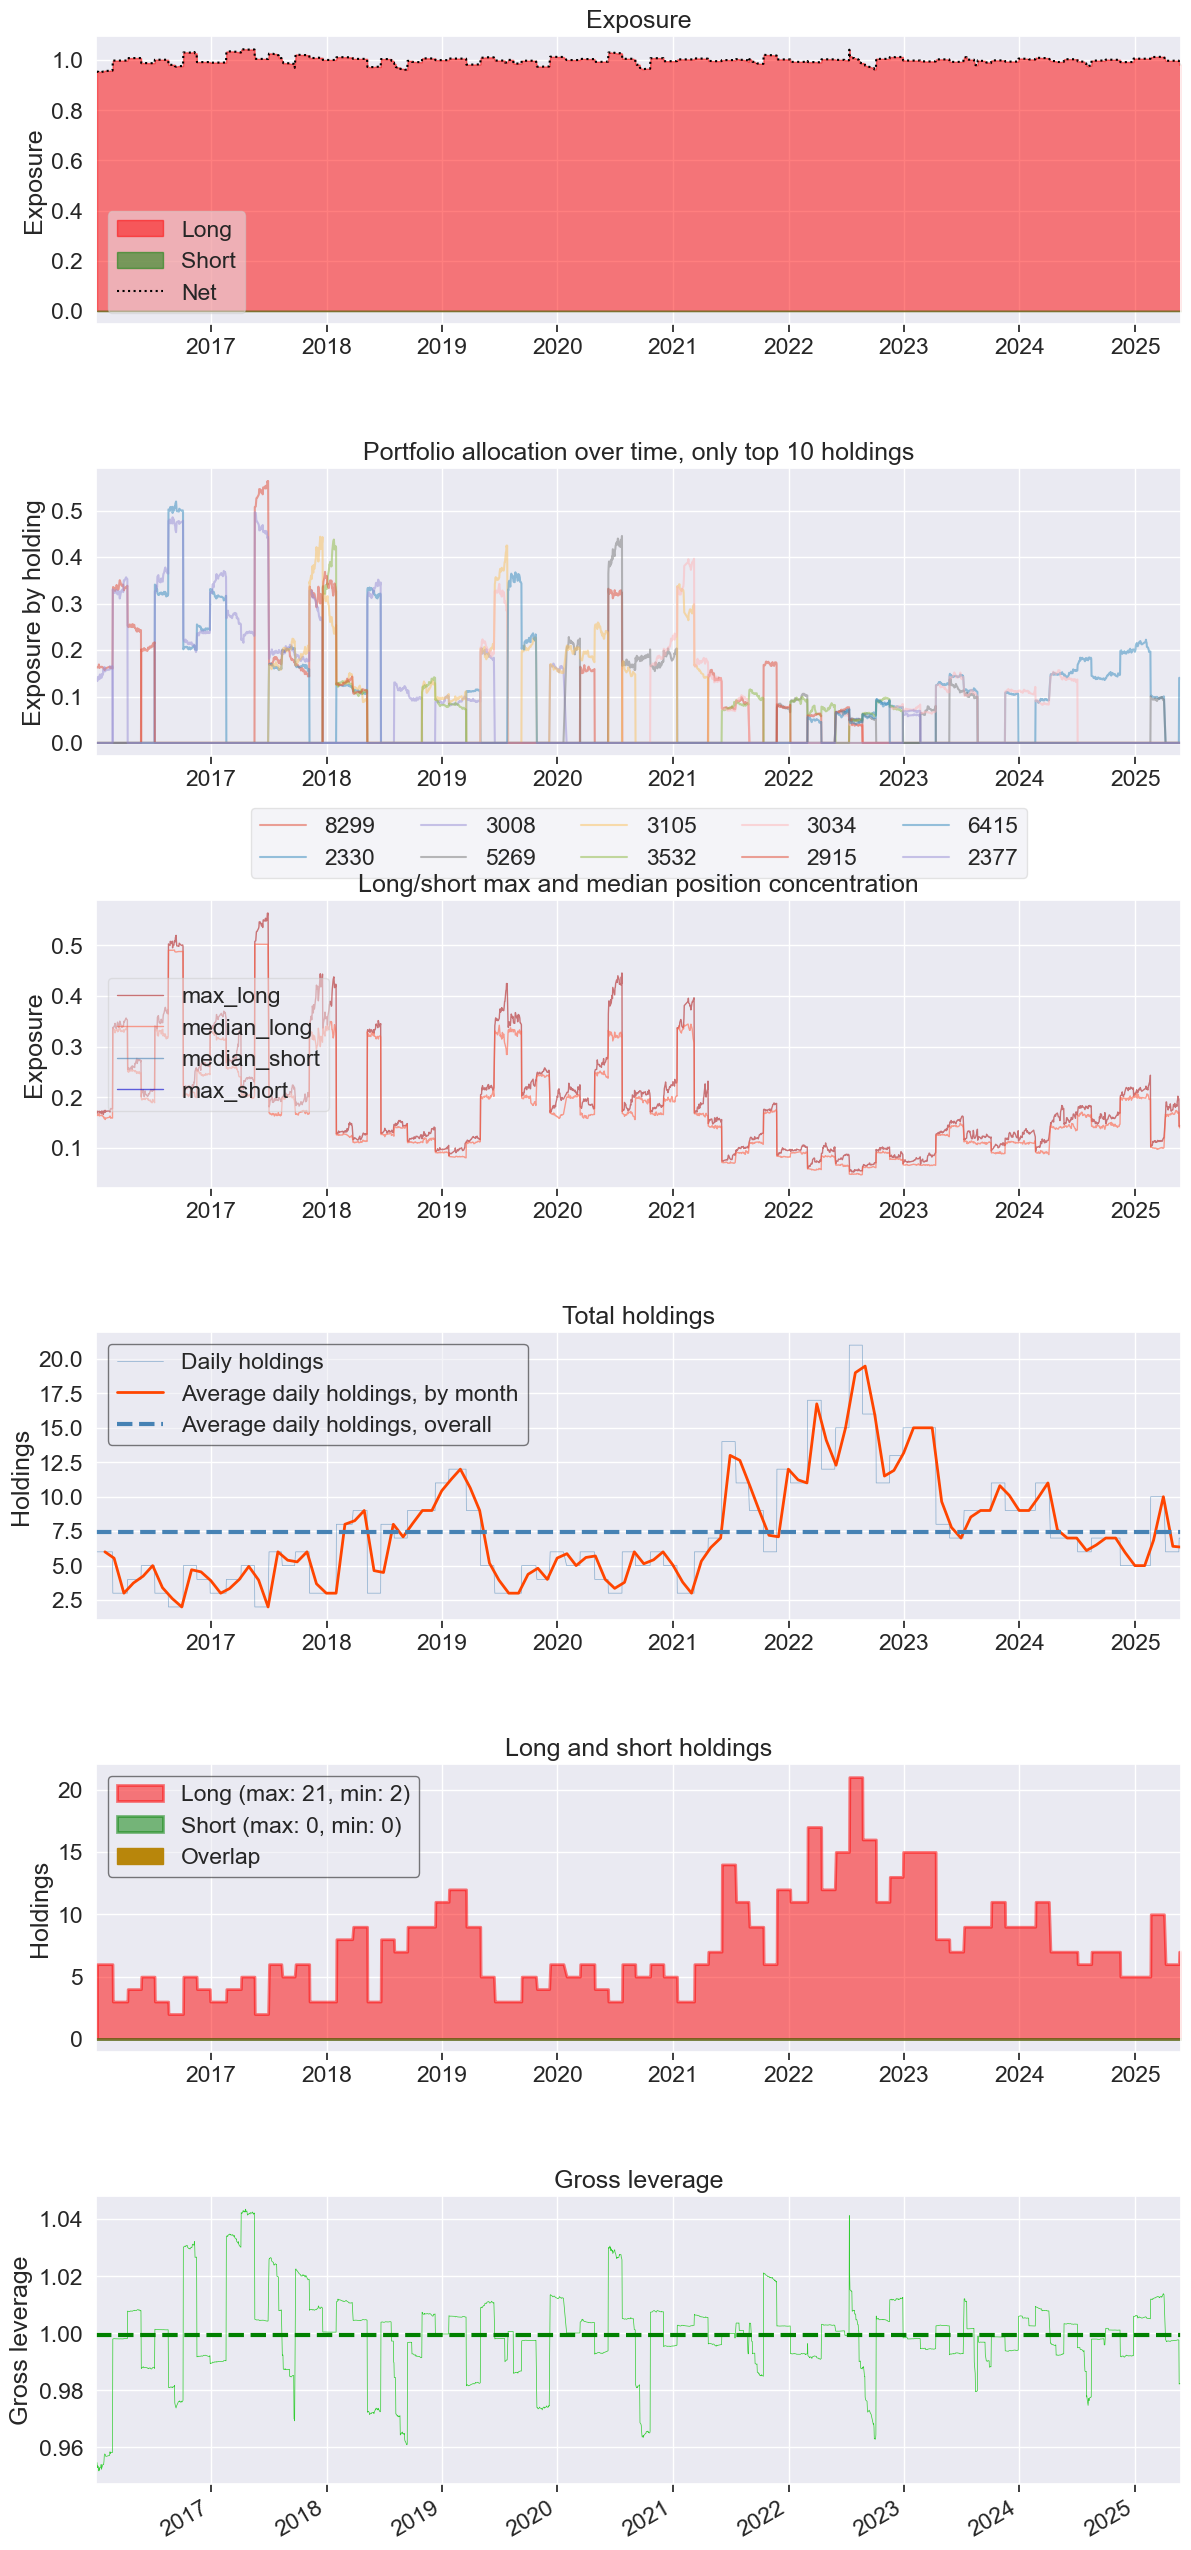

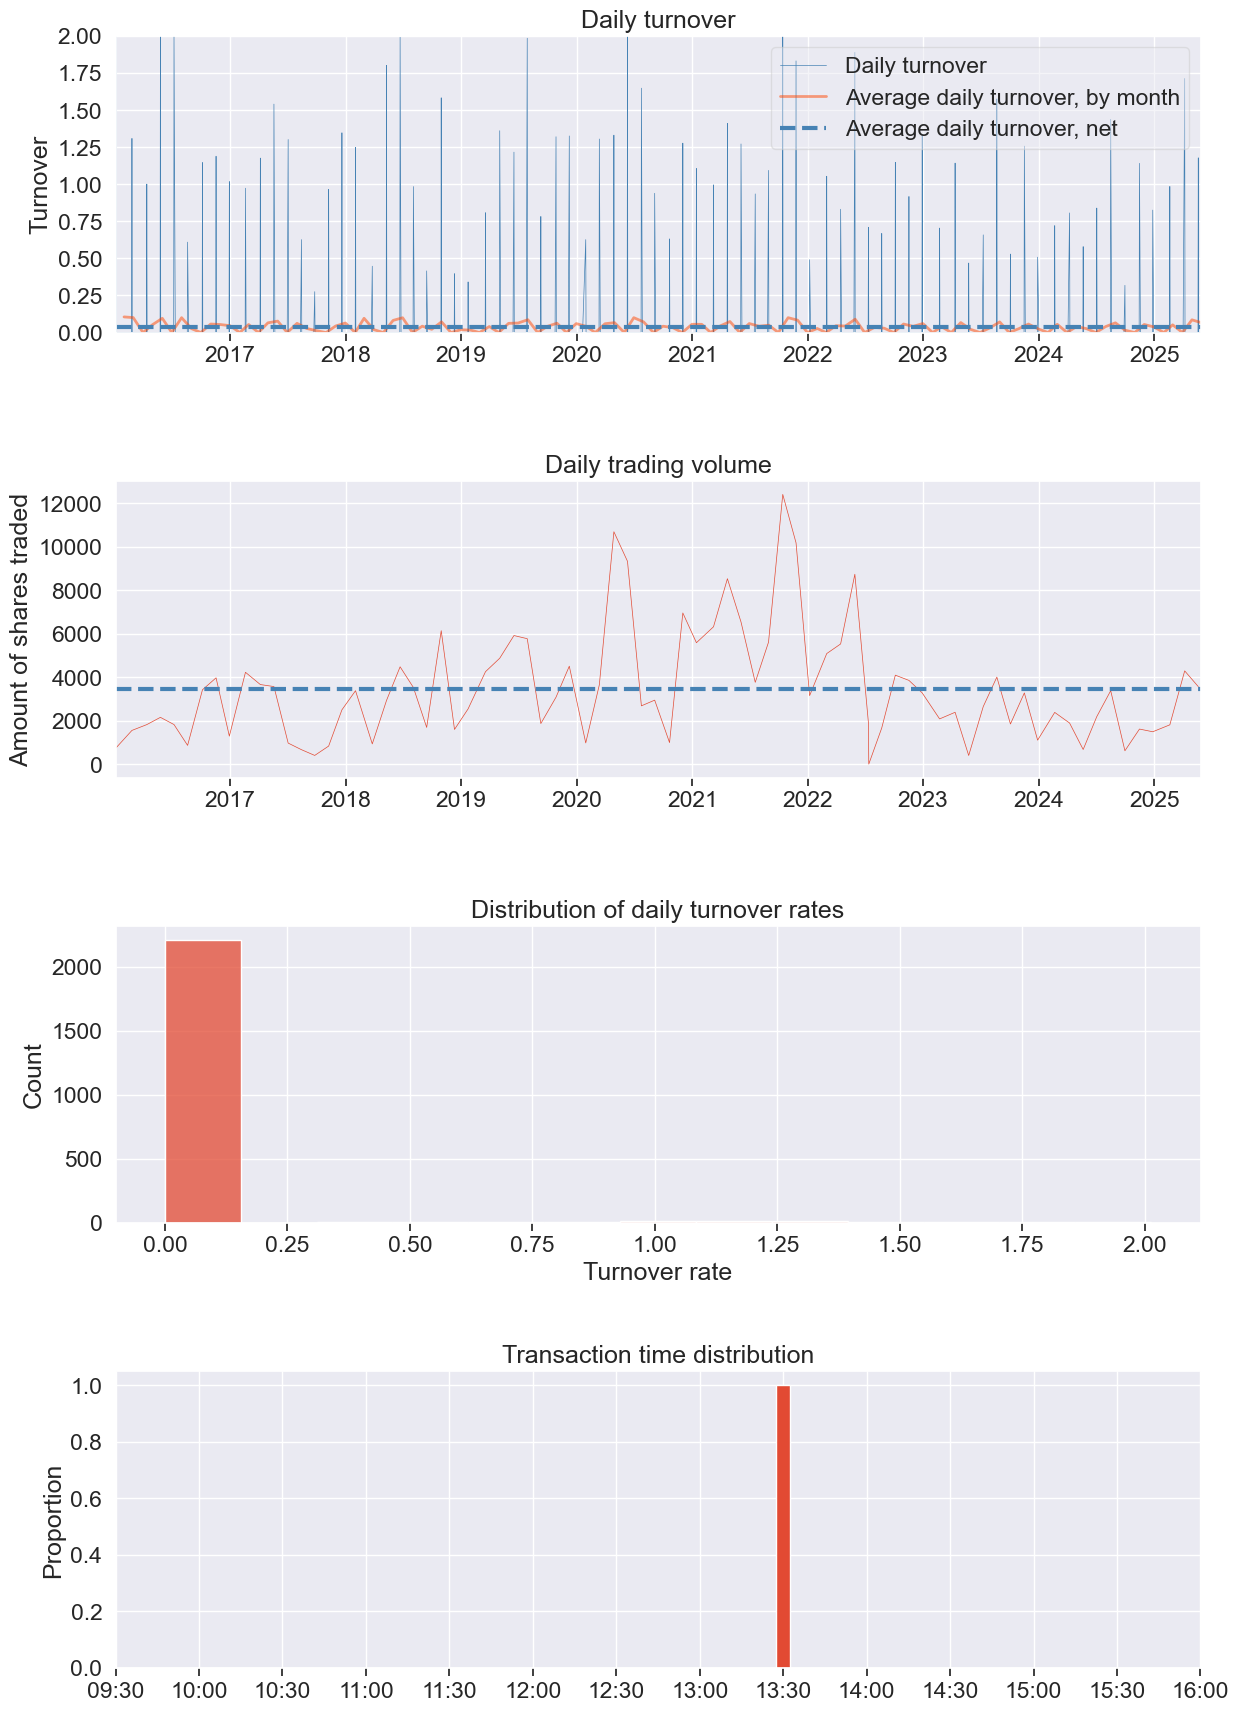

In [41]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )

In [45]:
def handle_data_ir0001(context, data):
    if context.i == 0:
        order_target_percent(symbol('IR0001'), 1.0)

    context.i += 1

def ana(context, perf):
    pass

results = run_algorithm(
            start = pd.Timestamp('2016-01-01', tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_ir0001,
            analyze = ana,
            bundle = 'tquant',
            capital_base = 1e5)


import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

from pyfolio.plotting import show_perf_stats
perf_stats = show_perf_stats(
    returns, 
    benchmark_rets, 
    positions, 
    transactions,   
)

Start date,2016-01-04
End date,2025-05-27
Total months,108
,Backtest
Annual return,14.486%
Cumulative returns,241.541%
Annual volatility,16.215%
Sharpe ratio,0.92
Calmar ratio,0.53
Stability,0.94
Max drawdown,-27.365%
